In [1]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import seaborn as sns
import pandas as pd

In [14]:
np.sqrt(np.sum(np.power(np.array([0,0,0]) - np.array([1,1,1]),2.0)))

1.7320508075688772

In [2]:
stims = np.array([[0,0,0],
         [0,0,1],
         [0,1,0],
         [0,1,1],
         [1,0,0],
         [1,0,1],
         [1,1,0],
         [1,1,1]], dtype=np.float32)

labels = np.array([
                    [0,0,0,0,1,1,1,1], # type 1
                    [0,0,1,1,1,1,0,0], # type 2
                    [1,1,1,0,0,1,0,0], # type 3
                    [1,1,1,0,1,0,0,0], # type 4
                    [1,1,1,0,0,0,0,1], # type 5
                    [1,0,0,1,0,1,1,0]  # type 6
                ], dtype=np.float32)


In [172]:
runs_df = []
for problem in range(labels.shape[0]):
    for i in range(100):
        model = keras.Sequential([
            layers.Dense(5, activation="relu"),
            layers.Dense(1, activation="sigmoid")
        ])
        model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.005), loss="binary_crossentropy", metrics=["accuracy"])
        history = model.fit(stims, labels[problem], epochs=100, batch_size=8, verbose=False)
        run_df=pd.DataFrame(history.history)
        run_df['error']=1.0-run_df['accuracy']
        run_df['block']=run_df.index
        run_df['run']=i
        run_df['problem']=problem+1
        runs_df.append(run_df)
runs_df = pd.concat(runs_df)


In [108]:
runs_df.head()

,loss,accuracy,error,block,run,problem
0,0.663492,0.750,0.250,0,0,0
1,0.658746,0.625,0.375,1,0,0
2,0.655073,0.625,0.375,2,0,0
3,0.652146,0.625,0.375,3,0,0
4,0.649537,0.625,0.375,4,0,0


<AxesSubplot:xlabel='block', ylabel='error'>

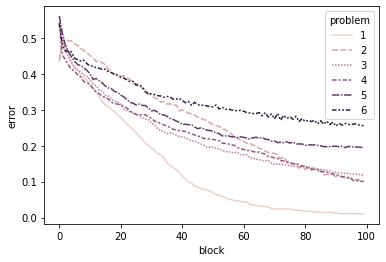

In [133]:
sns.lineplot(x='block',y='error',style='problem',hue='problem',data=runs_df.groupby(["block","problem"]).mean())

## Alcove Implementation

1. tracking the weights (callbacks)
2. custom loss to use humble teacher
(2b. it should 1 sigmoid 2 softmax)
3. use a different learning rate for attention than the output weights


In [50]:
class ALCOVE(keras.Model):
    def __init__(self, exemplars, c=6.5, phi=2.5):
        super().__init__()
        self.exemplars = tf.dtypes.cast(exemplars, tf.float32)
        self.ne = exemplars.shape[0]
        self.attn = tf.Variable(np.ones((3,))/3.0, dtype=tf.float32, trainable=True)
        self.output_layer = layers.Dense(1, activation="sigmoid", use_bias=False)  # later this should be two output and humble teacher loss
        self.c = c
        self.phi = phi

    def call(self, inputs):
        h_acts = []
        for n_ins in range(inputs.shape[0]):
            h_act = tf.math.exp(-self.c*tf.reduce_sum(self.attn*tf.math.abs(self.exemplars - inputs[n_ins]),1))
            h_acts.append(h_act)
        output = self.output_layer(tf.stack(h_acts))
        return output



In [49]:
model=ALCOVE(stims)
model(stims[6:7])

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.40135992]], dtype=float32)>

In [51]:
runs_df = []
for problem in range(labels.shape[0]):
    for i in range(2):
        model = ALCOVE(stims)
        model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.005), loss="binary_crossentropy", metrics=["accuracy"])
        history = model.fit(stims, labels[problem], epochs=100, batch_size=8, verbose=False)
        run_df=pd.DataFrame(history.history)
        run_df['error']=1.0-run_df['accuracy']
        run_df['block']=run_df.index
        run_df['run']=i
        run_df['problem']=problem+1
        runs_df.append(run_df)
runs_df = pd.concat(runs_df)

<AxesSubplot:xlabel='block', ylabel='error'>

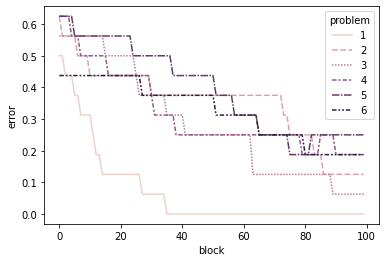

In [52]:
sns.lineplot(x='block',y='error',style='problem',hue='problem',data=runs_df.groupby(["block","problem"]).mean())